In [1]:
# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from torchsummary import summary

# Miscellaneous ML library imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import warnings
warnings.filterwarnings('ignore') # To ignore the big red future warnings (for now and convenience)

In [2]:
# Version checks
assert sys.version_info >= (3,10)

# to make this notebook's output stable across runs
SEED=42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Get available device for training
device = ( "cuda"     # CUDA for GPU compute
           if torch.cuda.is_available()
           else "cpu (no dice)" )   # CPU won't cut it. :P

print(f"{device} device available")

cuda device available


In [4]:
# Class containing various utility functions for this notebook
class SDUtils():

  # Global variables
  TRAIN = 0
  TEST = 1
  VALIDATION = 2
  HE_dir_prefix = ""
  IHC_dir_prefix = ""

  def __init__(self, masterPath=''):
    self.setDefaultDataPaths(masterPath)

  # util function to plot the original HE image, ground truth IHC image and transformed image from the diffuser model
  def plotImages(self, originalImageName, groundTruthImageName, ihcScore, dirType, transformedImage=None):
    
    if self.HE_dir_prefix == '' or self.IHC_dir_prefix == '':
      self.setDefaultDataPaths('')

    hePath, ihcPath = self.getDataPathFromType(dirType)
    originalImage = Image.open(f'{hePath}/{originalImageName}')
    groundTruthImage = Image.open(f'{ihcPath}/{groundTruthImageName}')
    imageDict = {'H&E Image (reference)': originalImage, 
                 f'IHC Image (ground truth), IHC score: {ihcScore}': groundTruthImage}
    
    if transformedImage is not None:
      imageDict['Generated IHC Image'] = transformedImage
      plt.figure(figsize=(15, 5))
    else:
      plt.figure(figsize=(10, 5))
    
    self.addImageToPlot(imageDict)
    plt.show()

  # Add image to plot
  def addImageToPlot(self, imageDict):
    numOfImages = len(imageDict)
    print(numOfImages)
    for i, (plotName, image) in enumerate(imageDict.items()):
      plt.subplot(1, numOfImages, i+1)
      plt.axis('off')
      plt.imshow(image)
      plt.title(plotName)

  # initialise data directory paths
  def setDefaultDataPaths(self, masterPath):
    if masterPath == '':
      masterPath = './datasets/BCI_dataset'

    # All dataset paths
    self.HE_dir_prefix = f'{masterPath}/HE'
    self.IHC_dir_prefix = f'{masterPath}/IHC'

  # Returns the folder path for HE and IHC images based on the type of data requested
  def getDataPathFromType(self, dirType):
    if dirType == self.TRAIN:
      subfolder = 'train'
    elif dirType == self.TEST:
      subfolder = 'test'
    elif dirType == self.VALIDATION:
      subfolder = 'validation'

    return f'{self.HE_dir_prefix}/{subfolder}', f'{self.IHC_dir_prefix}/{subfolder}'
  
  # Convert to 5 digit number i.e., pad with leading zeroes if necessary
  # This is useful because of the naming convention of image files in the BCI dataset
  def padZeroes(self, number, numDigits=5):
    return str(number).zfill(numDigits)


In [22]:
# Overriding the Dataset class so that it returns a tuple of corresponding HE and IHC images
class HE_IHC_Dataset(torch.utils.data.Dataset):
    def __init__(self, he_dir, ihc_dir, transform=None):
        self.he_dir = he_dir
        self.ihc_dir = ihc_dir
        self.transform = transform
        self.he_images = os.listdir(he_dir)
        self.ihc_images = os.listdir(ihc_dir)

        # Ensure both directories have the same number of images and corresponding names
        assert len(self.he_images) == len(self.ihc_images), "Number of images in HE and IHC directories must match"
        self.he_images.sort()  # Sort for consistency
        self.ihc_images.sort()

    def __len__(self):
        return len(self.he_images)        
    
    def __getitem__(self, idx):
        he_img_name = self.he_images[idx]
        ihc_img_name = self.ihc_images[idx]

        ihc_score = ''
        if '+' in he_img_name:
            pngIdx = he_img_name.index('.png')
            ihc_score = he_img_name[pngIdx-2:pngIdx]
        else:
            ihc_score = '0'

        he_img_path = os.path.join(self.he_dir, he_img_name)
        ihc_img_path = os.path.join(self.ihc_dir, ihc_img_name)

        he_image = Image.open(he_img_path).convert('RGB')
        ihc_image = Image.open(ihc_img_path).convert('RGB')

        if self.transform:
            he_image = self.transform(he_image)
            ihc_image = self.transform(ihc_image)

        return he_image, ihc_image, ihc_score

In [23]:
# Defining the image transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

sdUtil = SDUtils(masterPath='../datasets/BCI_dataset/')
train_he_dir, train_ihc_dir = sdUtil.getDataPathFromType(SDUtils.TRAIN)
test_he_dir, test_ihc_dir = sdUtil.getDataPathFromType(SDUtils.TEST)
# Create dataset instances
train_dataset = HE_IHC_Dataset(train_he_dir, train_ihc_dir, transform=transform)
test_dataset = HE_IHC_Dataset(test_he_dir, test_ihc_dir, transform=transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2


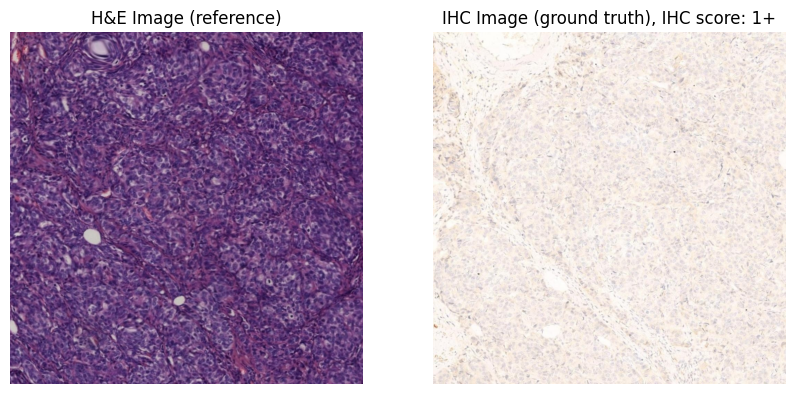

2


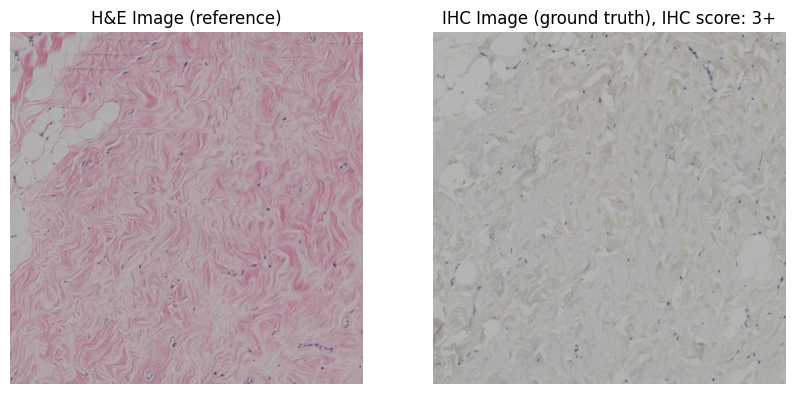

2


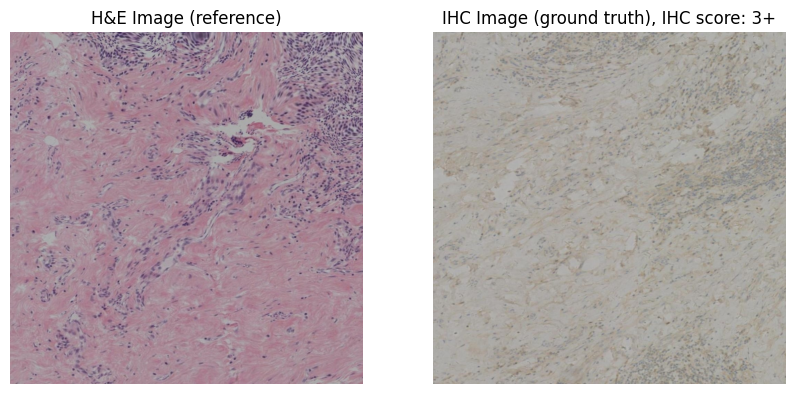

2


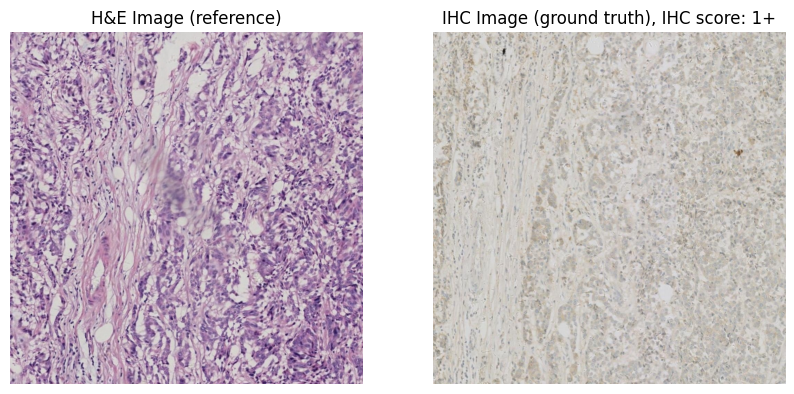

In [24]:
# Get the first 4 pairs of images
for i in range(4):
    heImage, ihcImage, ihcScore = train_dataset.__getitem__(i)
    imageNumber = sdUtil.padZeroes(i)
    sdUtil.plotImages(f'{imageNumber}_train_{ihcScore}.png', f'{imageNumber}_train_{ihcScore}.png', ihcScore, dirType=SDUtils.TRAIN)

In [21]:
# 
model = resnet50(pretrained=True)
num_classes = 4  # Number of classes in your dataset
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Step 4: Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Train the model

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    for HEImage, IHCImage, labels in train_loader:
        IHCImage = IHCImage.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(IHCImage)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


KeyboardInterrupt: 

In [ ]:
# Step 6: Evaluate the model

model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
print(f"Validation accuracy: {accuracy}")

# Step 7: Fine-tune the model (optional)

# TODO: Implement fine-tuning if needed